In [1]:
%%capture
!pip install JAEN -qU

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchinfo import summary
from JAEN.utils import plot_training_results
import os

# device 설정 (GPU가 사용 가능하면 GPU로, 그렇지 않으면 CPU 사용)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 데이터 로더 정의
from JAEN.datasets import load_titanic
# 데이터 파일이 저장된 경로 찾기
jaen_path = os.path.dirname(load_titanic.__code__.co_filename)
train_path = os.path.join(jaen_path, "data", "00", "train_loader.pt")
test_path = os.path.join(jaen_path, "data", "00", "test_loader.pt")

# torch.load()를 직접 실행 (weights_only=False 설정)
train_loader = torch.load(train_path, weights_only=False)
test_loader = torch.load(test_path, weights_only=False)

In [ ]:
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(7, 32)
        self.fc2 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# 모델 인스턴스 생성
model = DNN().to(device)
summary(model, (32, 7))

In [3]:
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(7, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(32)
        self.bn3 = nn.BatchNorm1d(16)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x

model = DNN().to(device)
summary(model, input_size = (32, 7))

Layer (type:depth-idx)                   Output Shape              Param #
DNN                                      [32, 1]                   --
├─Linear: 1-1                            [32, 64]                  512
├─BatchNorm1d: 1-2                       [32, 64]                  128
├─ReLU: 1-3                              [32, 64]                  --
├─Dropout: 1-4                           [32, 64]                  --
├─Linear: 1-5                            [32, 32]                  2,080
├─BatchNorm1d: 1-6                       [32, 32]                  64
├─ReLU: 1-7                              [32, 32]                  --
├─Linear: 1-8                            [32, 16]                  528
├─BatchNorm1d: 1-9                       [32, 16]                  32
├─ReLU: 1-10                             [32, 16]                  --
├─Linear: 1-11                           [32, 1]                   17
├─Sigmoid: 1-12                          [32, 1]                   --
Total par

In [4]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()  # 모델을 학습 모드로 설정

    running_loss = 0.0 # 미니 배치별 loss값을 누적할 변수

    for data, labels in train_loader: # 미니 배치 별 파라미터 업데이트 수행
        data, labels = data.to(device), labels.to(device) # 미니 배치별 데이터와 레이블 장치 할당

        # 순전파
        outputs = model(data)

        # 손실 계산
        loss = criterion(outputs, labels)

        # 기울기 초기화
        optimizer.zero_grad()

        # 역전파
        loss.backward()

        # 파라미터 업데이트
        optimizer.step()

        # 손실 누적
        running_loss += loss.item()

    # 현재 Epoch의 평균 손실 값 계산 및 반환
    return running_loss / len(train_loader)

In [5]:
# 평가 함수 정의
def evaluate(model, test_loader, criterion, device):
    model.eval()  # 모델을 평가 모드로 설정

    running_loss = 0.0 # 미니 배치별 loss값을 누적할 변수

    with torch.no_grad():  # 평가 중에는 기울기 계산을 하지 않음
        for data, labels in test_loader: # 미니 배치 별 손실 계산
            data, labels = data.to(device), labels.to(device) # 미니 배치별 데이터와 레이블 장치 할당

            # 순전파
            outputs = model(data)

            # 손실 계산
            loss = criterion(outputs, labels)

            # 손실 누적
            running_loss += loss.item()


    # 현재 Epoch의 평균 손실 값 계산 및 반환
    return running_loss / len(test_loader)

In [6]:
# 손실 함수와 옵티마이저 설정
criterion = nn.BCELoss()  # 이진 분류를 위한 손실 함수
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Adam 옵티마이저

In [7]:
train_losses = []
test_losses = []

# 학습 횟수 만큼 반복
for epoch in range(100):

    # 모델 학습(학습데이터)
    train_loss = train(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    # 모델 평가 (평가데이터)
    test_loss = evaluate(model, test_loader, criterion, device)
    test_losses.append(test_loss)

    print(f'Epoch {epoch+1} Train Loss : {train_loss} Test Loss : {test_loss}')

Epoch 1 Train Loss : 0.5506872327431388 Test Loss : 0.423578346769015
Epoch 2 Train Loss : 0.4333143493403559 Test Loss : 0.45174507796764374
Epoch 3 Train Loss : 0.43982584450555884 Test Loss : 0.429321085413297
Epoch 4 Train Loss : 0.4331683853398199 Test Loss : 0.4260505785544713
Epoch 5 Train Loss : 0.40913918484812195 Test Loss : 0.4110734512408574
Epoch 6 Train Loss : 0.3998056527065194 Test Loss : 0.43675777812798816
Epoch 7 Train Loss : 0.44205277121585346 Test Loss : 0.43507562081019086
Epoch 8 Train Loss : 0.442928504684697 Test Loss : 0.44456151127815247
Epoch 9 Train Loss : 0.4104777367218681 Test Loss : 0.4454941650231679
Epoch 10 Train Loss : 0.42789506912231445 Test Loss : 0.4490522692600886
Epoch 11 Train Loss : 0.40655005626056506 Test Loss : 0.4354313313961029
Epoch 12 Train Loss : 0.4126256769118102 Test Loss : 0.4347016165653865
Epoch 13 Train Loss : 0.4127333980539571 Test Loss : 0.4248857299486796
Epoch 14 Train Loss : 0.3873212842837624 Test Loss : 0.449568137526

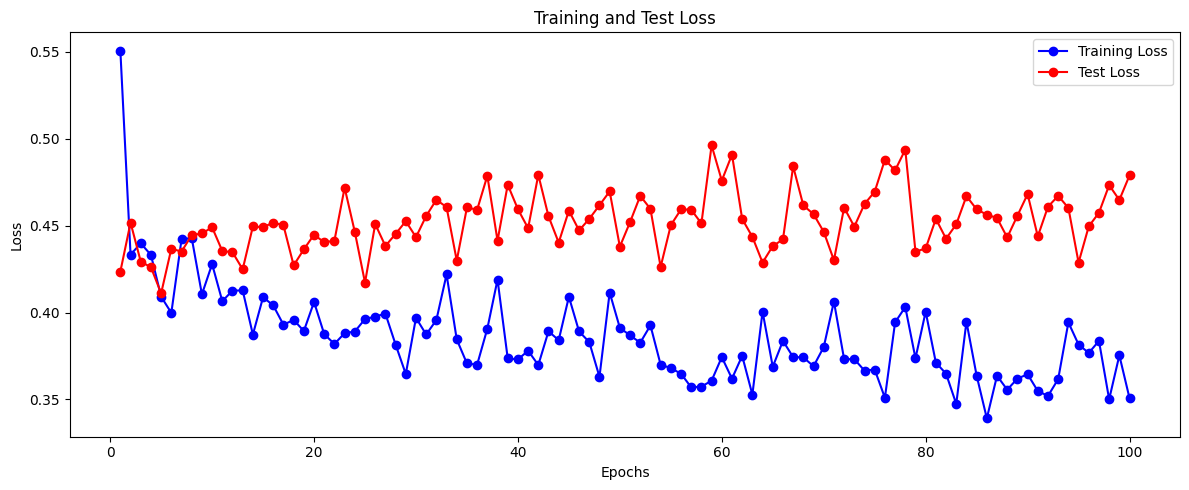

In [8]:
from JAEN.utils import plot_training_results
plot_training_results(train_losses, test_losses)